In [1]:
import numpy as np 
import scipy.stats as stats 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as linalg
sns.set()

In [2]:
#Установим значения параметров 
lambda_ = 7
mu = 2
k = 3
r = 3

<h3> Матрица переходных интенсивностей 

In [3]:
def make_Q(lambda_, mu, k, r):
    Q = np.zeros((k+r+1, k+r+1))
    Q[0][0], Q[0][1] = -lambda_, lambda_
    Q[k+r][k+r-1], Q[k+r][k+r] = k*mu, -k*mu
    for i in range(1, k+r):
        for j in range(0, k+r+1):
            if i == j - 1:
                Q[i][j] = lambda_
            if i == j + 1:
                if i <= k:
                    Q[i][j] = i*mu
                else:
                    Q[i][j] = k*mu
            if i == j:
                if i <= k:
                    Q[i][j] = -(lambda_ + i*mu)
                else:
                    Q[i][j] = -(lambda_ + k*mu)
    return Q
Q = make_Q(lambda_, mu, k, r)
print(Q)

[[ -7.   7.   0.   0.   0.   0.   0.]
 [  2.  -9.   7.   0.   0.   0.   0.]
 [  0.   4. -11.   7.   0.   0.   0.]
 [  0.   0.   6. -13.   7.   0.   0.]
 [  0.   0.   0.   6. -13.   7.   0.]
 [  0.   0.   0.   0.   6. -13.   7.]
 [  0.   0.   0.   0.   0.   6.  -6.]]


<h3> Матрица переходов 

In [4]:
def make_P(Q):
    P = np.zeros((k+r+1, k+r+1))
    for i in range(0, k+r+1):
        q_i = -Q[i][i]
        for j in range(0, k+r+1):
            if i != j:
                P[i][j] = Q[i][j]/q_i
    return P
P = make_P(Q)
print(P)

[[0.         1.         0.         0.         0.         0.
  0.        ]
 [0.22222222 0.         0.77777778 0.         0.         0.
  0.        ]
 [0.         0.36363636 0.         0.63636364 0.         0.
  0.        ]
 [0.         0.         0.46153846 0.         0.53846154 0.
  0.        ]
 [0.         0.         0.         0.46153846 0.         0.53846154
  0.        ]
 [0.         0.         0.         0.         0.46153846 0.
  0.53846154]
 [0.         0.         0.         0.         0.         1.
  0.        ]]


In [5]:
def stationary(M):
    evals, evecs = np.linalg.eig(M.T)
    evec1 = evecs[:,np.isclose(evals, 1)]
    evec1 = evec1[:,0]

    stationary = evec1 / evec1.sum()
    stationary = stationary.real
    
    return stationary 

<h2> №8.1

In [6]:
def generate(T, Q, P, plot=True):
    X = list()
    X.append(0)
    times = list()
    times.append(0)
    current_time = 0
    n = 0
    
    H = stats.expon.rvs(loc=0, scale=-1/Q[0][0], size=1)[0]
    current_time = H
    times.append(H)
    
    while current_time < T:
        i = X[n]
        mark = stats.rv_discrete(name='mark', values=(np.arange(7), P[i]))
        i = mark.rvs(size=1)[0]
        n += 1
        X.append(i)
        H = stats.expon.rvs(loc=0, scale=-1/Q[i][i], size=1)[0]
        current_time += H
        times.append(current_time)
    if plot:
        fig, ax = plt.subplots(figsize=(20, 7))
        ax.plot(times[0:len(times)-1], X, '-bo')
        ax.set_xlabel('time')
        ax.set_ylabel('X')
        ax.set_title('Изменение количествва клиентов в парихмахерской за {} ед. времени'.format(T))
        ax.hlines(3, 0, T, colors='r', linestyle='--')
        plt.show()
    
    return times, X

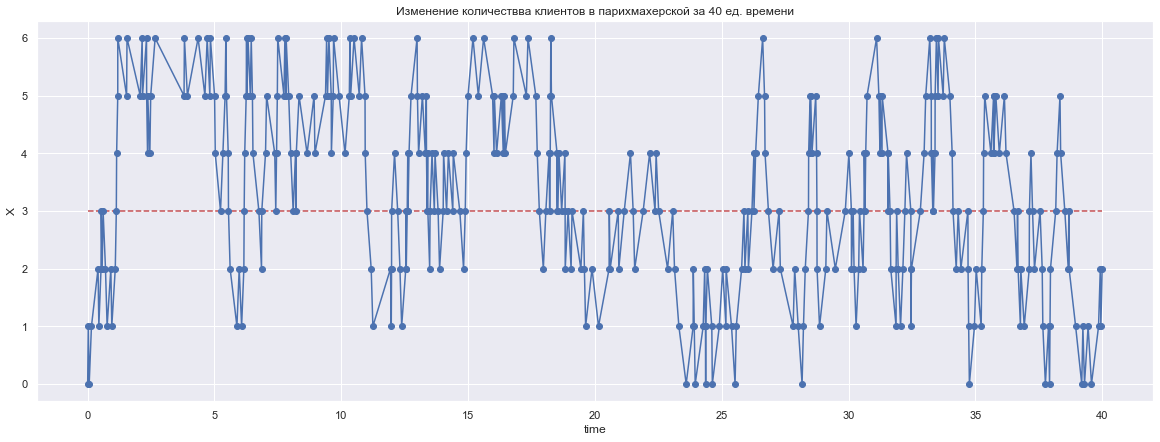

In [7]:
times, X = generate(40, Q, P, True)

<h3> Стационарное распределение 

$$\pi Q = 0 : \sum_{i \in S} \pi_i = 1 $$
Равносильнно:
$$ Q^T \pi = 0 $$

Решение для данной матрицы: $$(6^6/(7^7 - 6^7), 7*6^5 /(7^7 - 6^7), ..., 7^6 / (7^7 - 6^7 ) )  $$

In [8]:
station = list()
for i in range(1, 8):
    station.append((6**(7-i) * 7**(i - 1))/(7**7 - 6**7))
print(station)

[0.08582670936908465, 0.10013116093059876, 0.11681968775236522, 0.13628963571109276, 0.15900457499627488, 0.18550533749565404, 0.2164228937449297]


<h2> №8.2

<h3> a)

In [9]:
doli = np.zeros((100, Q.shape[0]))
for i in range(100):
    times, X = generate(40, Q, P, False)
    for j in range(len(X)):
        doli[i][X[j]] += times[j+1] - times[j]
    doli[i] = doli[i]/times[-1]

In [10]:
np.mean(doli, axis=0)

array([0.0261381 , 0.07485944, 0.12770337, 0.15081942, 0.17648748,
       0.2047411 , 0.23925109])

<h3> b)

<h4> Эмпирическое $ X_{30} $

In [33]:
empiric_X_30 = np.zeros(Q.shape[0])
for i in range(1000):
    _, X = generate(30, Q, P, False)
    empiric_X_30[X[30]] += 1
empiric_X_30 = empiric_X_30 / 1000
print(empiric_X_30)

[0.018 0.    0.287 0.    0.423 0.    0.272]


<h4> Теоретическое $ X_{30} $

In [36]:
np.linalg.matrix_power(P, 30)[0]

array([0.02816638, 0.        , 0.26998154, 0.        , 0.4316056 ,
       0.        , 0.27024649])

<h3> в)

In [84]:
Q_queu = make_Q(19, 1, 3, 3)
P_queu = make_P(Q_queu)

In [85]:
def overflow(T, Q, P):
    time_full_queu = 0
    times, X = generate(T, Q, P)
    for i in range(len(X)):
        if X[i] == Q.shape[0]-1:
            time_full_queu += times[i+1] - times[i]
    print('Очередь переолнена {}% времени'.format(round(time_full_queu/times[-1], 3)*100))

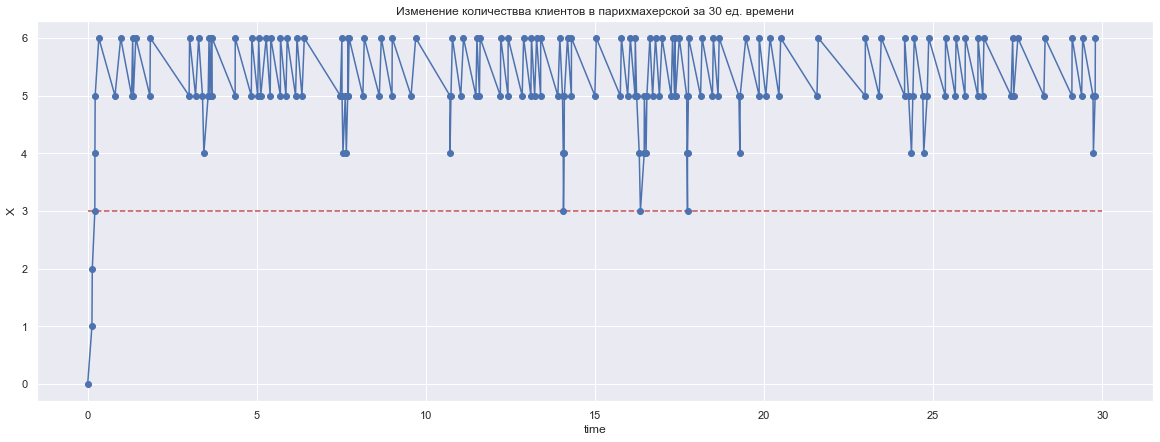

Очередь переолнена 0.845% времени


In [88]:
overflow(30, Q_queu, P_queu)

<h3> г)

In [ ]:
def estimate_Q(T, Q, P):
    times, X = generate(T, Q, P, False)